<a href="https://colab.research.google.com/github/Barryjuait/Barryjuait/blob/master/Personal%20Projects/Stock_Prices_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem Statement
Develop a 1D CNN model to forecast the price of the product for the next 7 days based on the last 30 days of historical data.

Solution Approach

Data Preprocessing
- Normalize the numerical variables (e.g., price, demand, competitor price).
- Convert categorical variables (e.g., day of the week) into numerical representations.
- Create a sliding window of 30 days as input and 7 days as output.
- Model Architecture:

  - Input: A (30, number of features) time series window.
  - 1D CNN layers:
    Conv1D (filters=64, kernel_size=3, activation='relu')
    Conv1D (filters=32, kernel_size=3, activation='relu')
    GlobalAveragePooling1D
  - Fully connected layers:
    Dense(64, activation='relu')
    Dense(7, activation='linear') (Output: Predict next 7 days' prices)
- Training
  - Loss function: Mean Squared Error (MSE)
  - Optimizer: Adam
  - Train for 50-100 epochs with early stopping.
- Evaluation
  - Compare predicted prices with actual prices using RMSE and MAPE.
  - Visualize forecasts vs. actual prices.

Challenges
- Handling missing values in pricing data.
- Incorporating external factors like promotions and seasonality.
- Avoiding overfitting due to limited data.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [32]:
# Set the path to the file you'd like to load
homeFolder = '/content/drive/MyDrive/Colab Notebooks/Forecasting/'
testFile = homeFolder + 'TSLA Testing.csv'
trainingFile = homeFolder + 'TSLA training.csv'

train_df =pd.read_csv(testFile)
test_df =pd.read_csv(trainingFile)

train_df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-06-22,234.503326,246.833328,233.826660,236.086670,236.086670,101107500
1,2022-06-23,237.906662,239.316666,228.636673,235.070007,235.070007,104202600
2,2022-06-24,237.470001,246.066666,236.086670,245.706665,245.706665,95770800
3,2022-06-27,249.366669,252.070007,242.566666,244.919998,244.919998,89178300
4,2022-06-28,244.483337,249.970001,232.343338,232.663330,232.663330,90391200


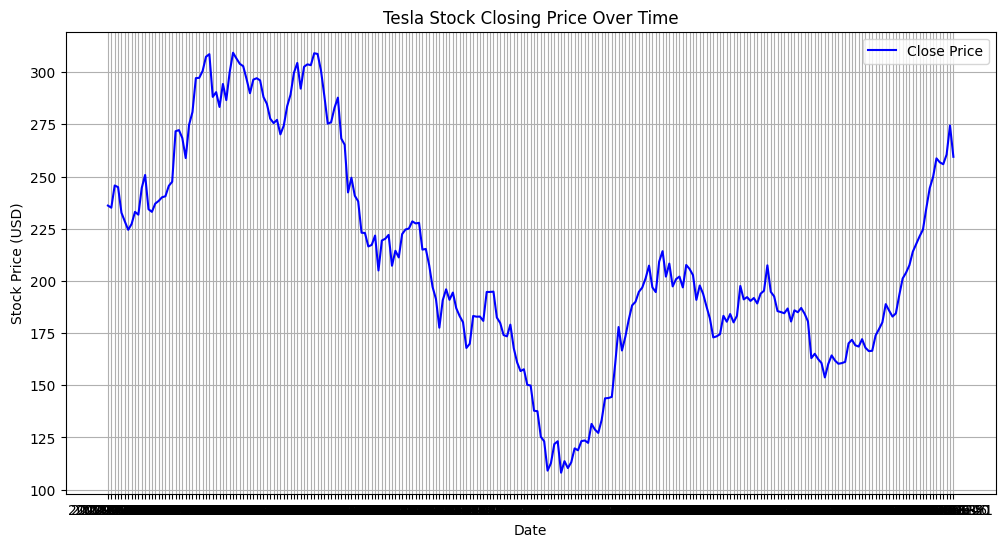

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Close'], label="Close Price", color='blue')
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Tesla Stock Closing Price Over Time")
plt.legend()
plt.grid()
plt.show()


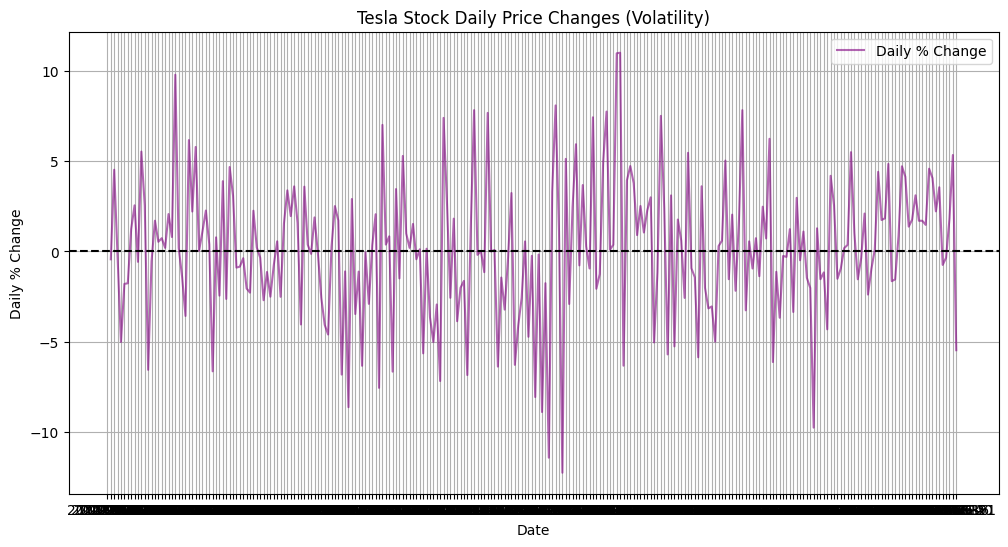

In [34]:
train_df['Daily Change'] = train_df['Close'].pct_change() * 100  # Convert to percentage

plt.figure(figsize=(12, 6))
plt.plot(train_df['Date'], train_df['Daily Change'], label="Daily % Change", color='purple', alpha=0.6)
plt.axhline(y=0, color='black', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("Daily % Change")
plt.title("Tesla Stock Daily Price Changes (Volatility)")
plt.legend()
plt.grid()
plt.show()


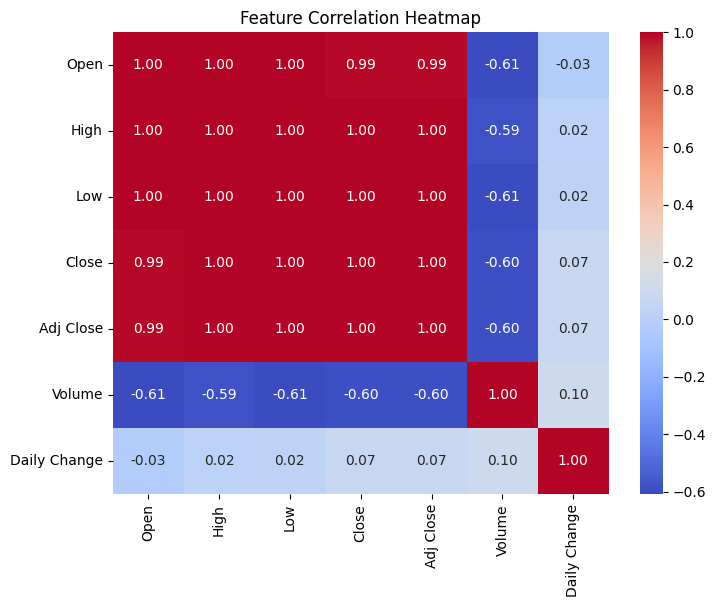

In [37]:
plt.figure(figsize=(8, 6))
sns.heatmap(train_df.drop(columns=['Date']).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


Predictive Model

In [28]:
#Date column to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Sort by Date
train_df = train_df.sort_values(by="Date")
test_df = test_df.sort_values(by="Date")

# Drop Date column (not needed for the model)
train_df = train_df.drop(columns=['Date'])
test_df = test_df.drop(columns=['Date'])

# Normalize data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

In [21]:
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Last 30 days as input
        y.append(data[i+seq_length, 3])  # Predict next day's closing price (Adj Close)
    return np.array(X), np.array(y)

SEQ_LENGTH = 30

X_train, y_train = create_sequences(train_scaled, SEQ_LENGTH)
X_test, y_test = create_sequences(test_scaled, SEQ_LENGTH)

# Reshape for 1D CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], SEQ_LENGTH, train_df.shape[1]))
X_test = X_test.reshape((X_test.shape[0], SEQ_LENGTH, test_df.shape[1]))


In [22]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, train_df.shape[1])),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer (regression task)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 28, 64)              │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 26, 32)              │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,569 (37.38 KB)

 Trainable params: 9,569 (37.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.1975 - mae: 0.3720 - val_loss: 0.1643 - val_mae: 0.3289
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0337 - mae: 0.1574 - val_loss: 0.1458 - val_mae: 0.3115
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0259 - mae: 0.1308 - val_loss: 0.1363 - val_mae: 0.2988
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0255 - mae: 0.1380 - val_loss: 0.1370 - val_mae: 0.3020
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0259 - mae: 0.1300 - val_loss: 0.1501 - val_mae: 0.3114
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0252 - mae: 0.1329 - val_loss: 0.1592 - val_mae: 0.3209
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0211 - mae: 0.1163 - val_loss: 0.1550 - val_mae: 0.3161
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0254 - mae: 0.1325 - val_loss: 0.1350 - val_mae: 0.2979
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.020

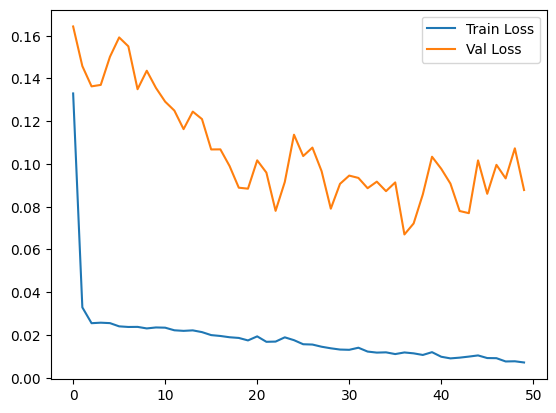

In [23]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


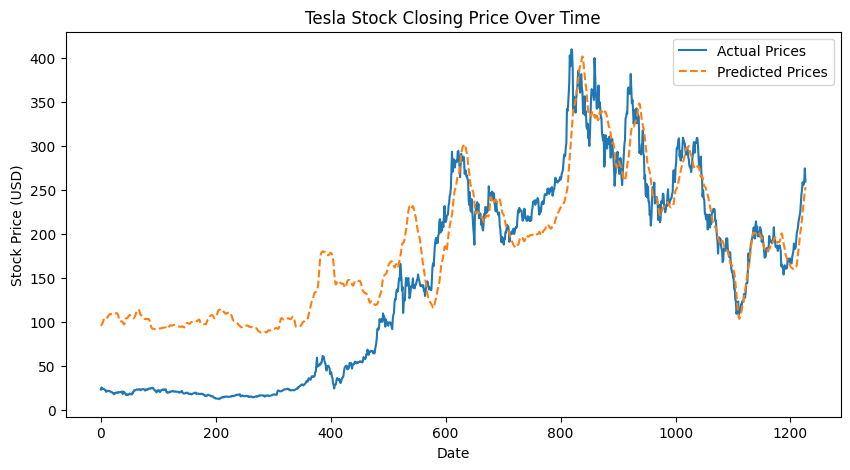

In [33]:
predictions = model.predict(X_test)

# Inverse transform predictions and actual values
y_test_actual = scaler.inverse_transform(test_scaled[SEQ_LENGTH:, :])[:, 3]  # Actual closing prices
predictions_actual = scaler.inverse_transform(np.hstack((test_scaled[SEQ_LENGTH:, :3],
                                                          predictions.reshape(-1,1),
                                                          test_scaled[SEQ_LENGTH:, 4:])))[:, 3]  # Predicted closing prices

# Plot actual vs predicted prices
plt.figure(figsize=(10, 5))
plt.plot(y_test_actual, label="Actual Prices")
plt.plot(predictions_actual, label="Predicted Prices", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title("Tesla Stock Closing Price Over Time")
plt.legend()
plt.show()


When is it a good moment to buy/sell??

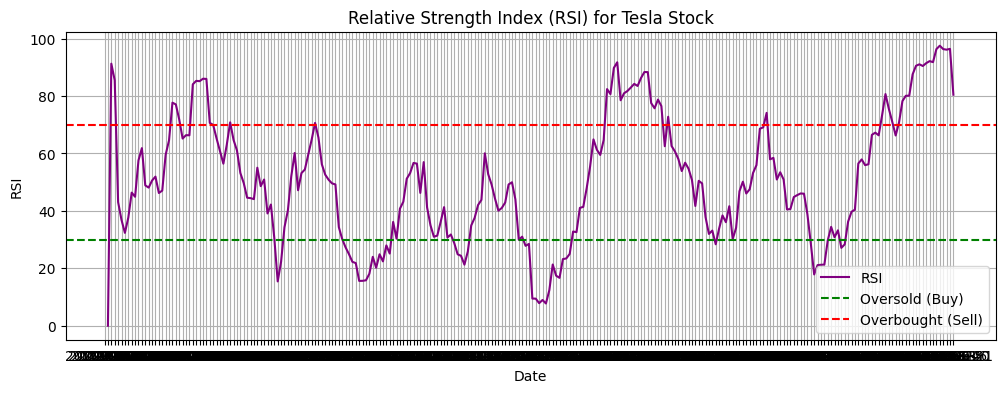

In [38]:
import numpy as np

# Compute RSI
def compute_RSI(data, window=14):
    delta = data.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=window, min_periods=1).mean()
    avg_loss = pd.Series(loss).rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

train_df['RSI'] = compute_RSI(train_df['Close'])

# Identify RSI buy/sell signals
train_df['RSI Buy'] = train_df['RSI'] < 30  # Oversold
train_df['RSI Sell'] = train_df['RSI'] > 70  # Overbought

# Plot RSI
plt.figure(figsize=(12, 4))
plt.plot(train_df['Date'], train_df['RSI'], label="RSI", color='purple')
plt.axhline(30, color='green', linestyle='dashed', label="Oversold (Buy)")
plt.axhline(70, color='red', linestyle='dashed', label="Overbought (Sell)")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.title("Relative Strength Index (RSI) for Tesla Stock")
plt.legend()
plt.grid()
plt.show()
